Telco Customer Churn Analysis
==========================

# 1. Understanding of the Data

The data is downloaded from kaggle, which is about telco customer churn analysis. The data contains information about a fictional telco company that provided home phone and Internet services to 7043 customers in California in Q3.

    - Description of data:

        - Demographics
            CustomerID: A unique ID that identifies each customer.
            Gender: The customer’s gender: Male, Female
            Age: The customer’s current age, in years, at the time the fiscal quarter ended.
            Senior Citizen: Indicates if the customer is 65 or older: Yes, No
            Married: Indicates if the customer is married: Yes, No
            Dependents: Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc.
            Number of Dependents: Indicates the number of dependents that live with the customer.

        - Location
            Country: The country of the customer’s primary residence.
            State: The state of the customer’s primary residence.
            City: The city of the customer’s primary residence.
            Zip Code: The zip code of the customer’s primary residence.
            Latitude: The latitude of the customer’s primary residence.
            Longitude: The longitude of the customer’s primary residence.
          
        - Service
            Tenure:Month the customer with the company
            Phone service: Indicates if the customer subscribes to home phone service with the company: Yes, No
            Multilines: Indicates if the customer subscribes to multiple telephone lines with the company: Yes, No
            Internet Service: Indicates if the customer subscribes to internet service with the company: Yes, No
            Online security: Indicates if the customer subscribes to an additional online security service provided by the company: Yes, No
            Similar as Online protection, Tech Support, Streaming TV, Streaming movies
            Contract: Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year.
            Paperless Billing: Indicates if the customer has chosen paperless billing: Yes, No
            Payment Method:Indicates how the customer pays their bill: Bank Withdrawal, Credit Card, Mailed Check
            Monthly Charges: Indicates the customer’s current total monthly charge for all their services from the company.
            Total Charges
            Churn Value: 1, 0 indicate whether the person has churned or not.
            
The total number of variables are 29. 
Now starts to import the dataset and clean the data.

# 2. Import & Clean dataset

## 2.1 Import dataset

In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

churn_data = pd.read_csv(r'C:\Users\Miaomiao Xu\Desktop\Churn Rate Analysis\Telco_customer_churn.csv')
churn_data.head()

,CustomerID,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,...,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,Churn Reason
0,3668-QPYBK,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,...,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,Competitor made better offer
1,9237-HQITU,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,...,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,Moved
2,9305-CDSKC,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,...,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,Moved
3,7892-POOKP,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,...,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,Moved
4,0280-XJGEX,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,...,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,Competitor had better devices


## 2.2 Drop Columns

In [2]:
churn_data.drop("Churn Label", axis=1, inplace=True)
churn_data.drop("Churn Score", axis=1, inplace=True)

## 2.3 Check null data

**Check:**

In [3]:
missing_data = churn_data.isnull()
missing_data = pd.DataFrame((~missing_data).all(), columns=['Any N/A'])
missing_data[~missing_data['Any N/A']]

,Any N/A
Churn Reason,False


I found out that total charge is object. Convert into float64 to see if there is a missing data.

In [4]:
churn_data['Total Charges'] = pd.to_numeric(churn_data['Total Charges'],
                                            errors='coerce')

In [5]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Country            7043 non-null   object 
 2   State              7043 non-null   object 
 3   City               7043 non-null   object 
 4   Zip Code           7043 non-null   int64  
 5   Lat Long           7043 non-null   object 
 6   Latitude           7043 non-null   float64
 7   Longitude          7043 non-null   float64
 8   Gender             7043 non-null   object 
 9   Senior Citizen     7043 non-null   object 
 10  Partner            7043 non-null   object 
 11  Dependents         7043 non-null   object 
 12  Tenure Months      7043 non-null   int64  
 13  Phone Service      7043 non-null   object 
 14  Multiple Lines     7043 non-null   object 
 15  Internet Service   7043 non-null   object 
 16  Online Security    7043 

There exists missing value in total charges. I want to see if total charge is ok to replace with 0.

In [6]:
churn_data[churn_data['Total Charges'].isnull()]['Tenure Months']

2234    0
2438    0
2568    0
2667    0
2856    0
4331    0
4687    0
5104    0
5719    0
6772    0
6840    0
Name: Tenure Months, dtype: int64

Therefore, it is ok to replace the null with 0. I also investigate into the original document, and there is a space in the cell, for which we cannot detect when the data type is incorrect.

**Replace:**

In [7]:
churn_data['Total Charges'].replace(np.nan, 0, inplace=True)

Now the total charges is the right form and no missing data in total charges.

## 2.4 Check duplicates

In [8]:
duplicates = churn_data['CustomerID'].duplicated()
duplicates.value_counts()

False    7043
Name: CustomerID, dtype: int64

## 2.5 Convert Data Type

### 2.5.1 Dummies

Several variables should convert into dummies:
- Senior Citizen
- Gender
- Partner
- Dependents
- Phone Service
- Multiple Lines
- Online Security
- Online Backup
- Device Protection
- Tech Support
- Streaming TV
- Streaming Movies
- Paperless Billing
- Internet

In [9]:
churn_data['Senior Citizen'] = np.where(churn_data['Senior Citizen'] == 'Yes',
                                        1, 0)

In [10]:
churn_data['Gender'] = np.where(churn_data['Gender'] == 'Male', 1, 0)

In [11]:
churn_data['Partner'] = np.where(churn_data['Partner'] == 'Yes', 1, 0)

In [12]:
churn_data['Dependents'] = np.where(churn_data['Dependents'] == 'Yes', 1, 0)

In [13]:
churn_data['Phone Service'] = np.where(churn_data['Phone Service'] == 'Yes', 1,
                                       0)

In [14]:
churn_data['Multiple Lines'] = np.where(churn_data['Multiple Lines'] == 'Yes',
                                        1, 0)

In [15]:
churn_data['Online Security'] = np.where(
    churn_data['Online Security'] == 'Yes', 1, 0)

In [16]:
churn_data['Internet'] = np.where(churn_data['Internet Service'] == 'Yes', 1,
                                       0)

In [17]:
churn_data['Online Backup'] = np.where(churn_data['Online Backup'] == 'Yes', 1,
                                       0)

In [18]:
churn_data['Device Protection'] = np.where(
    churn_data['Device Protection'] == 'Yes', 1, 0)

In [19]:
churn_data['Tech Support'] = np.where(churn_data['Tech Support'] == 'Yes', 1,
                                      0)

In [20]:
churn_data['Streaming TV'] = np.where(churn_data['Streaming TV'] == 'Yes', 1,
                                      0)

In [21]:
churn_data['Streaming Movies'] = np.where(
    churn_data['Streaming Movies'] == 'Yes', 1, 0)

In [22]:
churn_data['Paperless Billing'] = np.where(
    churn_data['Paperless Billing'] == 'Yes', 1, 0)

In [23]:
churn_data['Average Charges'] = np.where(churn_data['Total Charges'] / np.where(
        churn_data['Tenure Months'] == 0, 1, churn_data['Tenure Months'])<70.3,1,0)

In [24]:
churn_data['Internet-No'] = np.where(churn_data['Internet Service'] == 'No', 1, 0)
churn_data['Internet-DSL'] = np.where(churn_data['Internet Service'] == 'DSL', 1, 0)

In [25]:
churn_data['Contract_MonthtoMonth'] = np.where(churn_data['Contract'] == 'Month-to-month', 1, 0)
churn_data['Contract_OneYear'] = np.where(churn_data['Contract'] == 'One year', 1, 0)

In [26]:
churn_data['PM-Mailed check'] = np.where(churn_data['Payment Method'] == 'Mailed check', 1, 0)
churn_data['PM-Electronic check'] = np.where(churn_data['Payment Method'] == 'Electronic check', 1, 0)
churn_data['PM-Bank transfer (automatic)'] = np.where(churn_data['Payment Method'] == 'Bank transfer (automatic)', 1, 0)

### 2.5.2 Categorical Data

- Contract
- Payment Method

**Contract**

In [27]:
churn_data['Contract'].unique()

array(['Month-to-month', 'Two year', 'One year'], dtype=object)

In [28]:
churn_data['Contract'] = churn_data['Contract'].astype('category')

**Internet Service**

In [29]:
churn_data['Internet Service'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [30]:
churn_data['Internet Service'] = churn_data['Internet Service'].astype(
    'category')

**Payment Method**

In [31]:
churn_data['Payment Method'].unique()

array(['Mailed check', 'Electronic check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [32]:
churn_data['Payment Method'] = churn_data['Payment Method'].astype('category')

### 2.5.3 Bins

- Monthly Charges
- Total Charges
- Tenure Month

**Monthly Charges:**

In [33]:
churn_data['MonthlyChargesBinned'] = pd.qcut(churn_data['Monthly Charges'], 2)

**Total Charges:**

We can investigate into total charges or total average charges. Which one makes more sense? However, we can first binned those possible variables.

    - Total charges: this could be highly related with tenure month and monthly charges.
    - Average monthly charges:this could be similar with monthly charges.

In [34]:
churn_data['TotalChargesBinned'] = pd.qcut(churn_data['Total Charges'], 2)

In [35]:
churn_data['AverageChargesBinned'] = pd.qcut(
    (churn_data['Total Charges'] / np.where(
        churn_data['Tenure Months'] == 0, 1, churn_data['Tenure Months'])), 2)

**Tenure Months**

In [36]:
pd.qcut(churn_data['Tenure Months'], 2)

0       (-0.001, 29.0]
1       (-0.001, 29.0]
2       (-0.001, 29.0]
3       (-0.001, 29.0]
4         (29.0, 72.0]
             ...      
7038      (29.0, 72.0]
7039    (-0.001, 29.0]
7040      (29.0, 72.0]
7041    (-0.001, 29.0]
7042      (29.0, 72.0]
Name: Tenure Months, Length: 7043, dtype: category
Categories (2, interval[float64]): [(-0.001, 29.0] < (29.0, 72.0]]

In [37]:
 churn_data['Tenure Months'] = np.where(churn_data['Tenure Months'] < 29,
                                        1, 0)
    

**-------------------------------------------------Dataset cleaning is finished.-----------------------------------------**

**Show data info:**

In [38]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   CustomerID                    7043 non-null   object  
 1   Country                       7043 non-null   object  
 2   State                         7043 non-null   object  
 3   City                          7043 non-null   object  
 4   Zip Code                      7043 non-null   int64   
 5   Lat Long                      7043 non-null   object  
 6   Latitude                      7043 non-null   float64 
 7   Longitude                     7043 non-null   float64 
 8   Gender                        7043 non-null   int32   
 9   Senior Citizen                7043 non-null   int32   
 10  Partner                       7043 non-null   int32   
 11  Dependents                    7043 non-null   int32   
 12  Tenure Months                 7043 non-null   in

**---------------------------------------------------------------------section end-------------------------------------------------------------------**

# 3. Data EDAs

## 3.1 Overall Churn Plot

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
churn_yes = churn_data['Churn Value'].value_counts()[1]
churn_no = churn_data['Churn Value'].value_counts()[0]
churn_yes_per = churn_yes / churn_data.shape[0] * 100
churn_no_per = churn_no / churn_data.shape[0] * 100

Text(0.5, 1.05, 'Customer Churn Distribution')

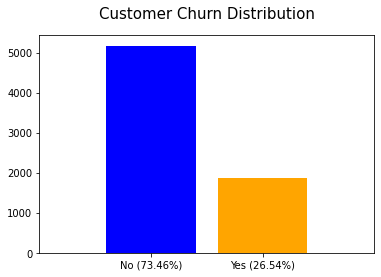

In [41]:
labels, counts = np.unique(churn_data['Churn Value'], return_counts=True)
plt.bar(x=labels, height=counts, align='center', color=['Blue', 'orange'])
plt.xlim(-1, 2)
plt.xticks((1, 0),
           [f'Yes ({churn_yes_per:.2f}%)', f'No ({churn_no_per:.2f}%)'])
plt.title('Customer Churn Distribution', size=15, y=1.05)

In [42]:
print(
    f'According to the graph above, the churn rate is about 26.54% last month. There are {churn_yes} people fail to keep subscribe our service.'
)

According to the graph above, the churn rate is about 26.54% last month. There are 1869 people fail to keep subscribe our service.


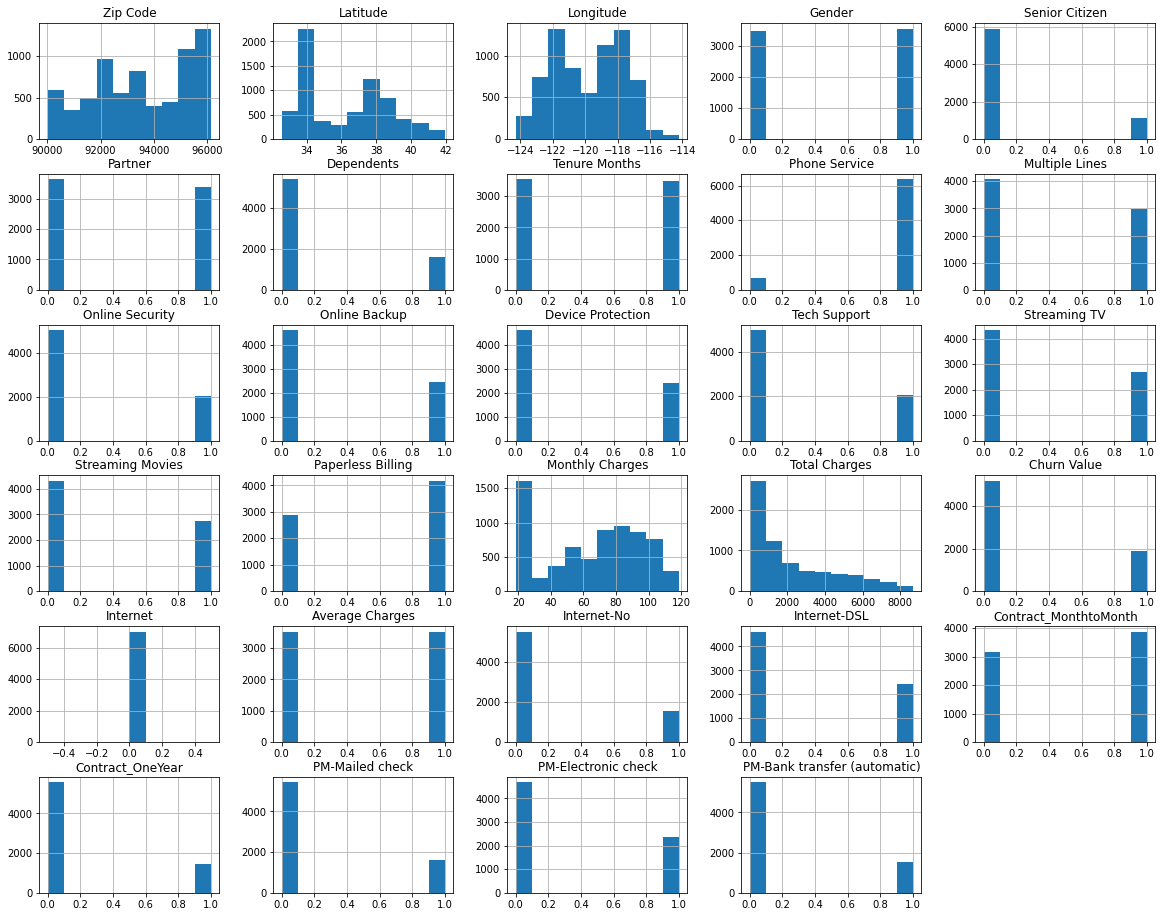

In [43]:
churn_data.hist(figsize=(20,16))
plt.show()  #showing the charts of different columns
#This also helps in finding number of counts in each column

## 3.2 Demographic Analysis

This session includes gender, age,dependent, marriage, and interactive data analysis.

### 3.2.1 Gender analysis

**Gender Number Output**

In [44]:
churn_count = churn_data.groupby(by=['Gender'])['Churn Value'].value_counts()
female_no_churn, female_churn, male_no_churn, male_churn = churn_count

female_churn_rate, male_churn_rate = churn_data.groupby(
    by=['Gender'])['Churn Value'].value_counts(normalize=True)[:, 1]

**Visulization**

[Text(0, 0, '3488'), Text(0, 0, '3555')]

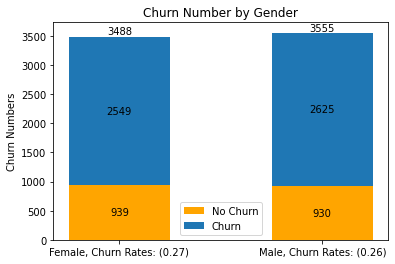

In [45]:
fig, ax = plt.subplots()

p1 = ax.bar(x=['Female', 'Male'],
            height=[female_churn, male_churn],
            width=0.5,
            color='orange')
p2 = ax.bar(x=['Female', 'Male'],
            height=[female_no_churn, male_no_churn],
            bottom=[female_churn, male_churn],
            width=0.5)

ax.set_ylabel('Churn Numbers')
ax.set_title('Churn Number by Gender')
plt.xticks((0, 1), [
    f'Female, Churn Rates: ({female_churn_rate:.2f})',
    f'Male, Churn Rates: ({male_churn_rate:.2f})'
])
ax.legend(['No Churn', 'Churn'])

ax.bar_label(p1, label_type='center')
ax.bar_label(p2, label_type='center')
ax.bar_label(p2)

In [46]:
print(
    'Female churn rate and male churn rate seem not to have much big differences.'
)
print(
    f'Female churn rate: {female_churn_rate:.3f}; male churn rate: {male_churn_rate:.3f}'
)

Female churn rate and male churn rate seem not to have much big differences.
Female churn rate: 0.269; male churn rate: 0.262


**Proportion Tests**

In [47]:
stat, pval = proportions_ztest(churn_count[:, 0],
                               churn_count.groupby(level=0).sum())
print(f'{pval:0.3f}')

0.470


We are confident to reject alternative hypothesis. There is no difference between churn rates of different genders.

### 3.2.2 Age Analysis

**Age Number Output**

In [48]:
age_count = churn_data.groupby(
    by=['Senior Citizen'])['Churn Value'].value_counts()
under60_no_churn, under60_churn, above60_no_churn, above60_churn = age_count

under60_churn_rate, above60_churn_rate = churn_data.groupby(
    by=['Senior Citizen'])['Churn Value'].value_counts(normalize=True)[:, 1]

**Visulization**

[Text(0, 0, '1142'), Text(0, 0, '5901')]

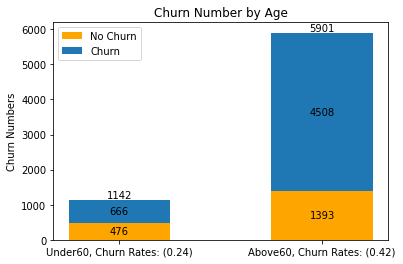

In [49]:
fig, ax = plt.subplots()

p1 = ax.bar(x=['Above60', 'Under60'],
            height=[above60_churn, under60_churn],
            width=0.5,
            color='orange')
p2 = ax.bar(x=['Above60', 'Under60'],
            height=[above60_no_churn, under60_no_churn],
            bottom=[above60_churn, under60_churn],
            width=0.5)

ax.set_ylabel('Churn Numbers')
ax.set_title('Churn Number by Age')
plt.xticks((0, 1), [
    f'Under60, Churn Rates: ({under60_churn_rate:.2f})',
    f'Above60, Churn Rates: ({above60_churn_rate:.2f})'
])
ax.legend(['No Churn', 'Churn'])

ax.bar_label(p1, label_type='center')
ax.bar_label(p2, label_type='center')
ax.bar_label(p2)

**Proportion Test**

In [50]:
stat, pval = proportions_ztest(age_count[:, 0],
                               age_count.groupby(level=0).sum())
print(f'{pval:0.3f}')

0.000


Therefore according to proportional test there do exists differences among age. The above 60 group have a higher churn rate than those under 60. What we could do is to understand why above 60 group have a higher churn rates and also focus on maintain low churn rate for those under 60.

Does age & gender have a co-impact on churn rates? We could also possibily look at that.

**Age & Gender**

In [51]:
# f: female; m: male; und: under 60 yo.; abv: above 60 yo.; n: no; y: yes
(f_und_n, f_und_y, f_abv_n, f_abv_y, m_und_n, m_und_y, m_abv_n,
 m_abv_y) = churn_data.groupby(
     by=['Gender', 'Senior Citizen'])['Churn Value'].value_counts()

[Text(0, 0, '2920'), Text(0, 0, '568'), Text(0, 0, '2981'), Text(0, 0, '574')]

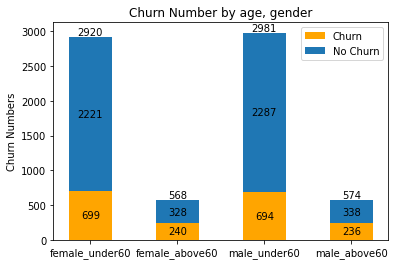

In [52]:
fig, ax = plt.subplots()

p1 = ax.bar(
    x=['female_under60', 'female_above60', 'male_under60', 'male_above60'],
    height=[f_und_y, f_abv_y, m_und_y, m_abv_y],
    width=0.5,
    color='orange')
p2 = ax.bar(
    x=['female_under60', 'female_above60', 'male_under60', 'male_above60'],
    height=[f_und_n, f_abv_n, m_und_n, m_abv_n],
    bottom=[f_und_y, f_abv_y, m_und_y, m_abv_y],
    width=0.5)

ax.set_ylabel('Churn Numbers')
ax.set_title('Churn Number by age, gender')

ax.legend(['Churn', 'No Churn'])

ax.bar_label(p1, label_type='center')
ax.bar_label(p2, label_type='center')
ax.bar_label(p2)

According to the graph above, if we see the differences considering both gender and age. There is no too much differences. I think only age have effects on churn rates. 
        
Why old people have a higher churn rates?
        
I guess people above 60 have a different life style. They may have lower addication to internet and TV, compared with people under 60. 

### 3.2.3 Partner Analysis

**Partner Number Output**

In [53]:
partner_count = churn_data.groupby(
    by=['Partner'])['Churn Value'].value_counts()
no_partner_no_churn, no_partner_churn, partner_no_churn, partner_churn = partner_count

no_partner_churn_rate, partner_churn_rate = churn_data.groupby(
    by=['Partner'])['Churn Value'].value_counts(normalize=True)[:, 1]

**Visulization**

[Text(0, 0, '3402'), Text(0, 0, '3641')]

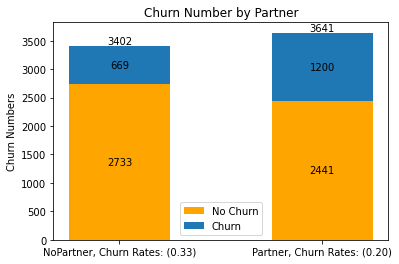

In [54]:
fig, ax = plt.subplots()

p1 = ax.bar(x=['Have Partner', 'No Partner'],
            height=[partner_no_churn, no_partner_no_churn],
            width=0.5,
            color='orange')
p2 = ax.bar(x=['Have Partner', 'No Partner'],
            height=[partner_churn, no_partner_churn],
            bottom=[partner_no_churn, no_partner_no_churn],
            width=0.5)

ax.set_ylabel('Churn Numbers')
ax.set_title('Churn Number by Partner')
plt.xticks((0, 1), [
    f'NoPartner, Churn Rates: ({no_partner_churn_rate:.2f})',
    f'Partner, Churn Rates: ({partner_churn_rate:.2f})'
])
ax.legend(['No Churn', 'Churn'])

ax.bar_label(p1, label_type='center')
ax.bar_label(p2, label_type='center')
ax.bar_label(p2)

**Proportion Test**

In [55]:
stat, pval = proportions_ztest(partner_count[:, 0],
                               partner_count.groupby(level=0).sum())
print(f'{pval:0.3f}')

0.000


According to the proportion test, it is confident to say that those have partner will be less easily to churn than those without partners, which is not the same with my expectation. 

### 3.2.4 Dependents Analysis:

**Dependents Number Output**

In [56]:
dependent_count = churn_data.groupby(
    by=['Dependents'])['Churn Value'].value_counts()
no_dependent_no_churn, no_dependent_churn, dependent_no_churn, dependent_churn = dependent_count

no_dependent_churn_rate, dependent_churn_rate = churn_data.groupby(
    by=['Dependents'])['Churn Value'].value_counts(normalize=True)[:, 1]

[Text(0, 0, '1627'), Text(0, 0, '5416')]

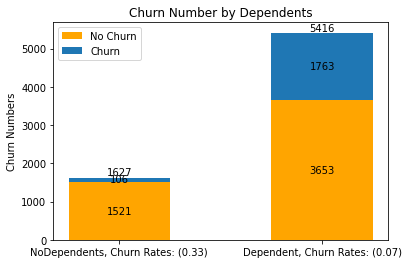

In [57]:
fig, ax = plt.subplots()

p1 = ax.bar(x=['Have Dependents', 'No Dependents'],
            height=[dependent_no_churn, no_dependent_no_churn],
            width=0.5,
            color='orange')
p2 = ax.bar(x=['Have Dependents', 'No Dependents'],
            height=[dependent_churn, no_dependent_churn],
            bottom=[dependent_no_churn, no_dependent_no_churn],
            width=0.5)

ax.set_ylabel('Churn Numbers')
ax.set_title('Churn Number by Dependents')
plt.xticks((0, 1), [
    f'NoDependents, Churn Rates: ({no_dependent_churn_rate:.2f})',
    f'Dependent, Churn Rates: ({dependent_churn_rate:.2f})'
])
ax.legend(['No Churn', 'Churn'])

ax.bar_label(p1, label_type='center')
ax.bar_label(p2, label_type='center')
ax.bar_label(p2)

**Proportional Test**

In [58]:
stat, pval = proportions_ztest(dependent_count[:, 0],
                               dependent_count.groupby(level=0).sum())
print(f'{pval:0.3f}')

0.000


We can conclude that there exists difference between users with dependents or without dependents. People have depdent have a lower churn rates compared with those have no dependents.

**Chi-square Test**

In [59]:
churn_data.groupby(by=['Partner', 'Dependents'])['Churn Value'].value_counts()

Partner  Dependents  Churn Value
0        0           0              2189
                     1              1150
         1           0               252
                     1                50
1        0           0              1464
                     1               613
         1           0              1269
                     1                56
Name: Churn Value, dtype: int64

In [60]:
from scipy.stats import chisquare

chisquare([2189, 252, 1464, 1269, 1150, 50, 613, 56])

Power_divergenceResult(statistic=4671.08433906006, pvalue=0.0)

There is a difference among groups.

Now we finished the demographical check. We could start to do geographic check.

## 3.3 Service Analysis

- GetPhoneService
- Internet 
- Online Support: Online Security, Online Backup, DeviceProtection, TechSupport
- StreamingTV
- StreamingMovies-Yes

### 3.3.1 Phone Service

Phone service include whether get a phone service and if get multilines.

**Phone Service Number Output**

In [61]:
PhoneService_count = churn_data.groupby(
    by=['Phone Service', 'Multiple Lines'])['Churn Value'].value_counts()
(no_PhoneService_no_churn, no_PhoneService_churn, SingleLine_no_churn, SingleLine_churn,
 MultiLine_no_churn,MultiLine_churn)= PhoneService_count

no_PhoneService_churn_rate = churn_data.groupby(
    by=['Phone Service'])['Churn Value'].value_counts(normalize=True)[:, 1][0]
SingleLine_churn_rate, MultipleLines_churn_rate = churn_data.groupby(
    by=['Phone Service', 'Multiple Lines'])['Churn Value'].value_counts(normalize=True)[1][:,1]

**Visulization**

[Text(0, 0, '682'), Text(0, 0, '3390'), Text(0, 0, '2971')]

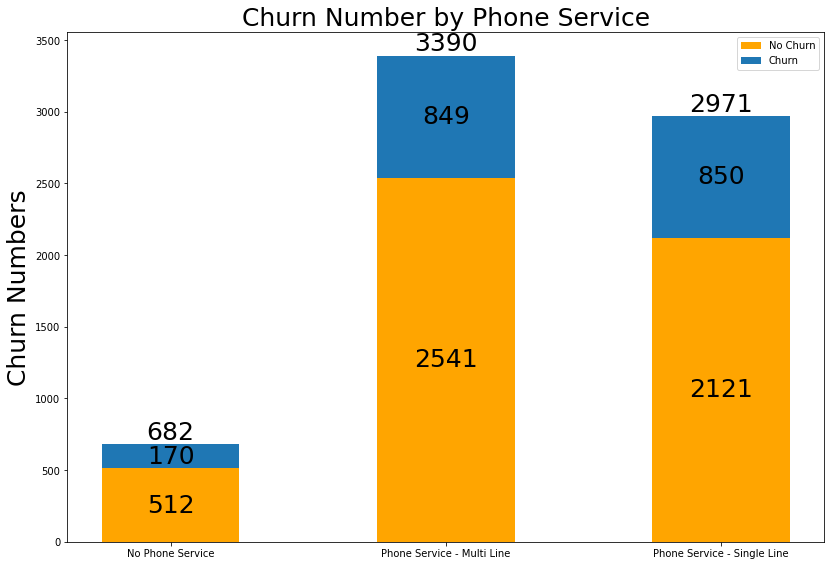

In [62]:
# figure settings
figure_width = 28.7  # cm
figure_height = 20  # cm
left_right_magrin = 1  # cm
top_bottom_margin = 1  # cm

# Don't change
left = left_right_magrin / figure_width  # Percentage from height
bottom = top_bottom_margin / figure_height  # Percentage from height
width = 1 - left * 2
height = 1 - bottom * 2
cm2inch = 1 / 2.54  # inch per cm

# specifying the width and the height of the box in inches
fig = plt.figure(figsize=(figure_width * cm2inch, figure_height * cm2inch))
ax = fig.add_axes((left, bottom, width, height))

p1 = ax.bar(
    x=[
        'No Phone Service', 'Phone Service - Multi Line',
        'Phone Service - Single Line'
    ],
    height=[no_PhoneService_no_churn, SingleLine_no_churn, MultiLine_no_churn],
    width=0.5,
    color='orange')
p2 = ax.bar(
    x=[
        'No Phone Service', 'Phone Service - Multi Line',
        'Phone Service - Single Line'
    ],
    height=[no_PhoneService_churn, SingleLine_churn, MultiLine_churn],
    bottom=[no_PhoneService_no_churn, SingleLine_no_churn, MultiLine_no_churn],
    width=0.5)

ax.set_ylabel('Churn Numbers', size=25)
ax.set_title('Churn Number by Phone Service', size=25)

ax.legend(['No Churn', 'Churn'])

ax.bar_label(p1, label_type='center', fontsize=25)
ax.bar_label(p2, label_type='center', fontsize=25)
ax.bar_label(p2, fontsize=25)

In [63]:
print('No phone service churn rate: ' + str(round(no_PhoneService_churn_rate, 4)))
print('Single Line churn rate: ' + str(round(SingleLine_churn_rate, 4)))
print('Multi Line churn rate: ' + str(round(MultipleLines_churn_rate, 4)))

No phone service churn rate: 0.2493
Single Line churn rate: 0.2504
Multi Line churn rate: 0.2861


**Chi-Square Test**

It seems like there is no much differences between these rates. However, multi line churn rates is relatively higher among all.
We may do a test to confirm that.

*H0:p1=p2=p3*

We use chi square test to test that.

In [64]:
chisquare([170, 849, 850, 512, 2541, 2121])

Power_divergenceResult(statistic=3767.450376260117, pvalue=0.0)

The phone service does have an effect on churn rate.

### 3.3.2 Internet Service

**Number Output**

In [65]:
DSL_churn = churn_data.groupby(
    by=['Internet Service'])['Churn Value'].value_counts()['DSL'][1]
DSL_no_churn = churn_data.groupby(
    by=['Internet Service'])['Churn Value'].value_counts()['DSL'][0]
FO_churn = churn_data.groupby(
    by=['Internet Service'])['Churn Value'].value_counts()['Fiber optic'][1]
FO_no_churn = churn_data.groupby(
    by=['Internet Service'])['Churn Value'].value_counts()['Fiber optic'][0]
No_Internet_churn = churn_data.groupby(
    by=['Internet Service'])['Churn Value'].value_counts()['No'][1]
No_Internet_no_churn = churn_data.groupby(
    by=['Internet Service'])['Churn Value'].value_counts()['No'][0]

DSL_rate = DSL_churn / churn_data['Internet Service'].value_counts()['DSL']
FO_rate = FO_churn / churn_data['Internet Service'].value_counts(
)['Fiber optic']
No_Internet_rate = No_Internet_churn / churn_data[
    'Internet Service'].value_counts()['No']

[Text(0, 0, '1526'), Text(0, 0, '2421'), Text(0, 0, '3096')]

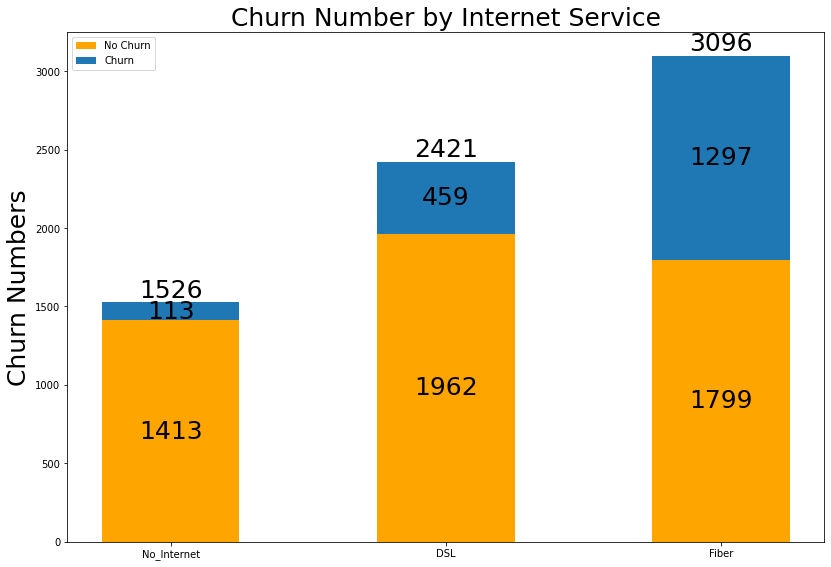

In [66]:
# figure settings
figure_width = 28.7  # cm
figure_height = 20  # cm
left_right_magrin = 1  # cm
top_bottom_margin = 1  # cm

# Don't change
left = left_right_magrin / figure_width  # Percentage from height
bottom = top_bottom_margin / figure_height  # Percentage from height
width = 1 - left * 2
height = 1 - bottom * 2
cm2inch = 1 / 2.54  # inch per cm

# specifying the width and the height of the box in inches
fig = plt.figure(figsize=(figure_width * cm2inch, figure_height * cm2inch))
ax = fig.add_axes((left, bottom, width, height))

p1 = ax.bar(x=['No_Internet', 'DSL', 'Fiber'],
            height=[No_Internet_no_churn, DSL_no_churn, FO_no_churn],
            width=0.5,
            color='orange')
p2 = ax.bar(x=['No_Internet', 'DSL', 'Fiber'],
            height=[No_Internet_churn, DSL_churn, FO_churn],
            bottom=[No_Internet_no_churn, DSL_no_churn, FO_no_churn],
            width=0.5)

ax.set_ylabel('Churn Numbers', size=25)
ax.set_title('Churn Number by Internet Service', size=25)

ax.legend(['No Churn', 'Churn'])

ax.bar_label(p1, label_type='center', fontsize=25)
ax.bar_label(p2, label_type='center', fontsize=25)
ax.bar_label(p2, fontsize=25)

In [67]:
print('No internet churn rate:' + str(round(No_Internet_rate, 4)))
print('Internet DSL churn rate:' + str(round(DSL_rate, 4)))
print('Internet FO churn rate:' + str(round(FO_rate, 4)))

No internet churn rate:0.074
Internet DSL churn rate:0.1896
Internet FO churn rate:0.4189


In [68]:
obs = np.array([[113, 459, 1297], [1413, 1962, 1799]]).T
chisquare(obs)

Power_divergenceResult(statistic=array([1189.84269663,   92.18515655]), pvalue=array([4.25540854e-259, 9.59947757e-021]))

There exists differences of the churn rate of those whether have internet service and what service they subscribed.

It seems like there are large differences between churn rates among these service. I believe customers with DSL have lower churn rates among all service. Does Internet Fiber Optical have any possible updates to fulfill user experience. What is the difference between DSL and Fiber optical? What is Internet Fiber target group?

**Subquestion: Internet Fiber & DSL target group?**

In [69]:
churn_data[(churn_data['Internet Service'] == 'DSL')][[
    'Gender', 'Senior Citizen', 'Partner', 'Dependents'
]].value_counts()

Gender  Senior Citizen  Partner  Dependents
1       0               0        0             500
0       0               0        0             494
1       0               1        0             310
0       0               1        0             292
                                 1             226
1       0               1        1             217
0       1               0        0              71
1       0               0        1              70
        1               0        0              63
                        1        0              63
0       0               0        1              53
        1               1        0              40
                                 1              12
1       1               1        1               8
                        0        1               2
dtype: int64

Most DSL user is uder60 and may not have dependents. DSL targets on young users.

In [70]:
churn_data[(churn_data['Internet Service'] == 'Fiber optic')][[
    'Gender', 'Senior Citizen', 'Partner', 'Dependents'
]].value_counts()

Gender  Senior Citizen  Partner  Dependents
1       0               0        0             564
0       0               0        0             562
                        1        0             360
1       0               1        0             351
0       1               0        0             233
1       1               1        0             220
        0               1        1             191
0       0               1        1             171
1       1               0        0             166
0       1               1        0             164
        0               0        1              36
1       0               0        1              30
0       1               1        1              21
1       1               1        1              18
0       1               0        1               6
1       1               0        1               3
dtype: int64

Most Fiber users does not have dependents but have partners.

### 3.3.3 Internet Protection

Does internet protection help to decrease the churn rate?

- Several variable we could look at:
    - OnlineSecurity-Yes   
    - OnlineBackup-Yes
    - DeviceProtection-Yes
    - TechSupport-Yes
- Visulization
- Possible tests

**Number Output**

In [71]:
OnlineSecurity = churn_data['Online Security'].value_counts()[1]
OnlineBackup = churn_data['Online Backup'].value_counts()[1]
DeviceProtection = churn_data['Device Protection'].value_counts()[1]
TechSupport = churn_data['Tech Support'].value_counts()[1]

In [72]:
OnlineSecurity_churn = churn_data.groupby(
    by=['Online Security'])['Churn Value'].value_counts()[1][1]
OnlineSecurity_no_churn = churn_data.groupby(
    by=['Online Security'])['Churn Value'].value_counts()[1][0]

In [73]:
OnlineBackup_churn = churn_data.groupby(
    by=['Online Backup'])['Churn Value'].value_counts()[1][1]
OnlineBackup_no_churn = churn_data.groupby(
    by=['Online Backup'])['Churn Value'].value_counts()[1][0]

In [74]:
DeviceProtection_churn = churn_data.groupby(
    by=['Device Protection'])['Churn Value'].value_counts()[1][1]
DeviceProtection_no_churn = churn_data.groupby(
    by=['Device Protection'])['Churn Value'].value_counts()[1][0]

In [75]:
TechSupport_churn = churn_data.groupby(
    by=['Tech Support'])['Churn Value'].value_counts()[1][1]
TechSupport_no_churn = churn_data.groupby(
    by=['Tech Support'])['Churn Value'].value_counts()[1][0]

**Visulization**

[Text(0, 0, '2019'),
 Text(0, 0, '2429'),
 Text(0, 0, '2422'),
 Text(0, 0, '2044')]

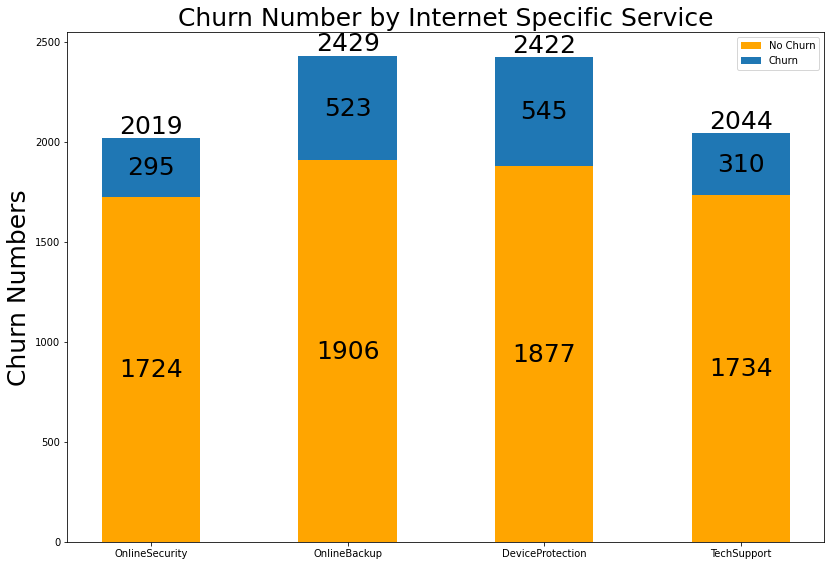

In [76]:
# figure settings
figure_width = 28.7  # cm
figure_height = 20  # cm
left_right_magrin = 1  # cm
top_bottom_margin = 1  # cm

# Don't change
left = left_right_magrin / figure_width  # Percentage from height
bottom = top_bottom_margin / figure_height  # Percentage from height
width = 1 - left * 2
height = 1 - bottom * 2
cm2inch = 1 / 2.54  # inch per cm

# specifying the width and the height of the box in inches
fig = plt.figure(figsize=(figure_width * cm2inch, figure_height * cm2inch))
ax = fig.add_axes((left, bottom, width, height))

p1 = ax.bar(
    x=['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport'],
    height=[
        OnlineSecurity_no_churn, OnlineBackup_no_churn,
        DeviceProtection_no_churn, TechSupport_no_churn
    ],
    width=0.5,
    color='orange')
p2 = ax.bar(
    x=['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport'],
    bottom=[
        OnlineSecurity_no_churn, OnlineBackup_no_churn,
        DeviceProtection_no_churn, TechSupport_no_churn
    ],
    height=[
        OnlineSecurity_churn, OnlineBackup_churn, DeviceProtection_churn,
        TechSupport_churn
    ],
    width=0.5)

ax.set_ylabel('Churn Numbers', size=25)
ax.set_title('Churn Number by Internet Specific Service', size=25)

ax.legend(['No Churn', 'Churn'])

ax.bar_label(p1, label_type='center', fontsize=25)
ax.bar_label(p2, label_type='center', fontsize=25)
ax.bar_label(p2, fontsize=25)

**Chi Square Test**

In [77]:
obs = np.array([[295, 523, 545, 310], [2037, 1855, 1884, 2027]]).T
chisquare(obs)

Power_divergenceResult(statistic=array([128.98206814,  13.77764962]), pvalue=array([8.96258489e-28, 3.22397675e-03]))

According to chi-square test, there exists significant differences of churn rates by internet specific service. I may think the online security and tech support are most important feature our user want to have. I may recommend to put more effort in promoting and updating these two functions.

### 3.3.4 Streaming Service

**Variables check:** 
    
    - StreamingTV-Yes
    - StreamingMovies-Yes

In [78]:
StreamingTV_churn = len(churn_data[(churn_data['Streaming TV'] == 1)
                                   & (churn_data['Churn Value'] == 1)])
StreamingTV_no_churn = len(churn_data[(churn_data['Streaming TV'] == 0)
                                      & (churn_data['Churn Value'] == 0)])
StreamingMovies_churn = len(churn_data[(churn_data['Streaming Movies'] == 1)
                                       & (churn_data['Churn Value'] == 1)])
StreamingMovies_no_churn = len(churn_data[(churn_data['Streaming Movies'] == 0)
                                          & (churn_data['Churn Value'] == 0)])

**Visulization**

[Text(0, 0, '4095'), Text(0, 0, '4078')]

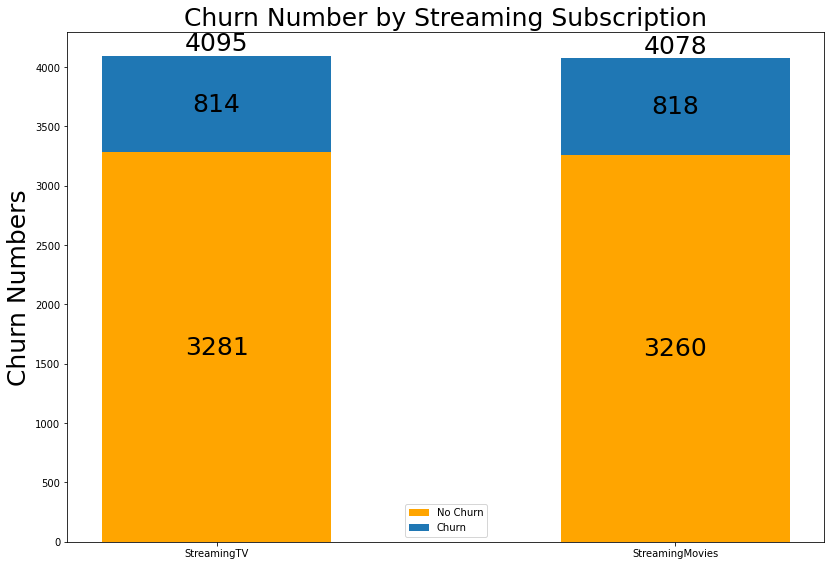

In [79]:
# specifying the width and the height of the box in inches
fig = plt.figure(figsize=(figure_width * cm2inch, figure_height * cm2inch))
ax = fig.add_axes((left, bottom, width, height))

p1 = ax.bar(x=['StreamingTV', 'StreamingMovies'],
            height=[StreamingTV_no_churn, StreamingMovies_no_churn],
            width=0.5,
            color='orange')
p2 = ax.bar(x=['StreamingTV', 'StreamingMovies'],
            bottom=[StreamingTV_no_churn, StreamingMovies_no_churn],
            height=[StreamingTV_churn, StreamingMovies_churn],
            width=0.5)

ax.set_ylabel('Churn Numbers', size=25)
ax.set_title('Churn Number by Streaming Subscription', size=25)

ax.legend(['No Churn', 'Churn'])

ax.bar_label(p1, label_type='center', fontsize=25)
ax.bar_label(p2, label_type='center', fontsize=25)
ax.bar_label(p2, fontsize=25)

**Proper tests**

In [80]:
count = np.array([814, 818])
nobs = np.array([3281, 3260])
stat, pval = proportions_ztest(count, nobs)
print(round(stat, 2), round(pval, 2))

-0.26 0.79


## 3.4 Payment Analysis

- Several Variables:
       - Payment Method      
       - Monthly Charges 
       - Total Charges 
       - PaperlessBilling 

### 3.4.1 Payment Method

First, we need to know **how many** payment method is here:

In [81]:
tb1 = churn_data['Payment Method'].value_counts().rename_axis(
    'Payment Method').reset_index(name='counts')
tb1

,Payment Method,counts
0,Electronic check,2365
1,Mailed check,1612
2,Bank transfer (automatic),1544
3,Credit card (automatic),1522


Most people choose to use the electronic check. I believe the reason is it is fast and efficient to make a transfer.

Next, I want to see the churn rates among these method.

In [82]:
tb2 = churn_data.groupby(
    by=['Payment Method'])['Churn Value'].value_counts().rename_axis(
        ['Payment Method', 'Churn Value']).reset_index(name='churn counts')
tb2

,Payment Method,Churn Value,churn counts
0,Bank transfer (automatic),0,1286
1,Bank transfer (automatic),1,258
2,Credit card (automatic),0,1290
3,Credit card (automatic),1,232
4,Electronic check,0,1294
5,Electronic check,1,1071
6,Mailed check,0,1304
7,Mailed check,1,308


In [83]:
tb3 = pd.merge(tb2, tb1, left_on='Payment Method', right_on='Payment Method')
tb3['percent'] = tb3['churn counts'] / tb3['counts']
tb3[tb3['Churn Value'] == 1]

,Payment Method,Churn Value,churn counts,counts,percent
1,Bank transfer (automatic),1,258,1544,0.167098
3,Credit card (automatic),1,232,1522,0.152431
5,Electronic check,1,1071,2365,0.452854
7,Mailed check,1,308,1612,0.191067


Although many people chooseto use electronic check, it shows that it has the highest churn rates among all method. I think there exists some problem using elcectronic check purchasing our service. I would recommend to investigate what is happening and improve the payment service.

### 3.4.2 Monthly Charges


In [84]:
churn_data.groupby(by=['MonthlyChargesBinned'])['Churn Value'].value_counts()

MonthlyChargesBinned  Churn Value
(18.249, 70.35]       0              2896
                      1               632
(70.35, 118.75]       0              2278
                      1              1237
Name: Churn Value, dtype: int64

In [85]:
churn_data.groupby(
    by=['MonthlyChargesBinned'])['Churn Value'].value_counts(normalize=True)[:, 1]

MonthlyChargesBinned
(18.249, 70.35]    0.179138
(70.35, 118.75]    0.351920
Name: Churn Value, dtype: float64

### 3.4.3 Total Charges

There is two measurement of total charges:
- Average charges
- Total charges

Which one makes more sense?

Compared with monthly charges, is total charges valuable to be included?

In [86]:
churn_data.groupby(by=['TotalChargesBinned'])['Churn Value'].value_counts()

TotalChargesBinned  Churn Value
(-0.001, 1394.55]   0              2313
                    1              1209
(1394.55, 8684.8]   0              2861
                    1               660
Name: Churn Value, dtype: int64

In [87]:
churn_data.groupby(
    by=['TotalChargesBinned'])['Churn Value'].value_counts(normalize=True)[:, 1]

TotalChargesBinned
(-0.001, 1394.55]    0.343271
(1394.55, 8684.8]    0.187447
Name: Churn Value, dtype: float64

In [88]:
churn_data.groupby(by=['AverageChargesBinned'] )['Churn Value'].value_counts()

AverageChargesBinned  Churn Value
(-0.001, 70.3]        0              2881
                      1               642
(70.3, 121.4]         0              2293
                      1              1227
Name: Churn Value, dtype: int64

In [89]:
churn_data.groupby(
    by=['AverageChargesBinned'])['Churn Value'].value_counts(normalize=True)[:, 1]

AverageChargesBinned
(-0.001, 70.3]    0.182231
(70.3, 121.4]     0.348580
Name: Churn Value, dtype: float64

According to analysis above, I think if the average spending is higher, the churn rates is higher, which is similar with the monthly charges. However, if the total spending is higher, the churn rate is lower. 

Therefore, as measure for total churn rates, we can also use the tenure months.

**Tenure Month**

In [90]:
churn_data.groupby(
    by=['Tenure Months'])['Churn Value'].value_counts(normalize=True)[:, 1]

Tenure Months
0    0.133954
1    0.398627
Name: Churn Value, dtype: float64

In the model, I think I will include average monthly charge binned and tenure months binned.

## 3.5 Correlation Plot

<AxesSubplot:>

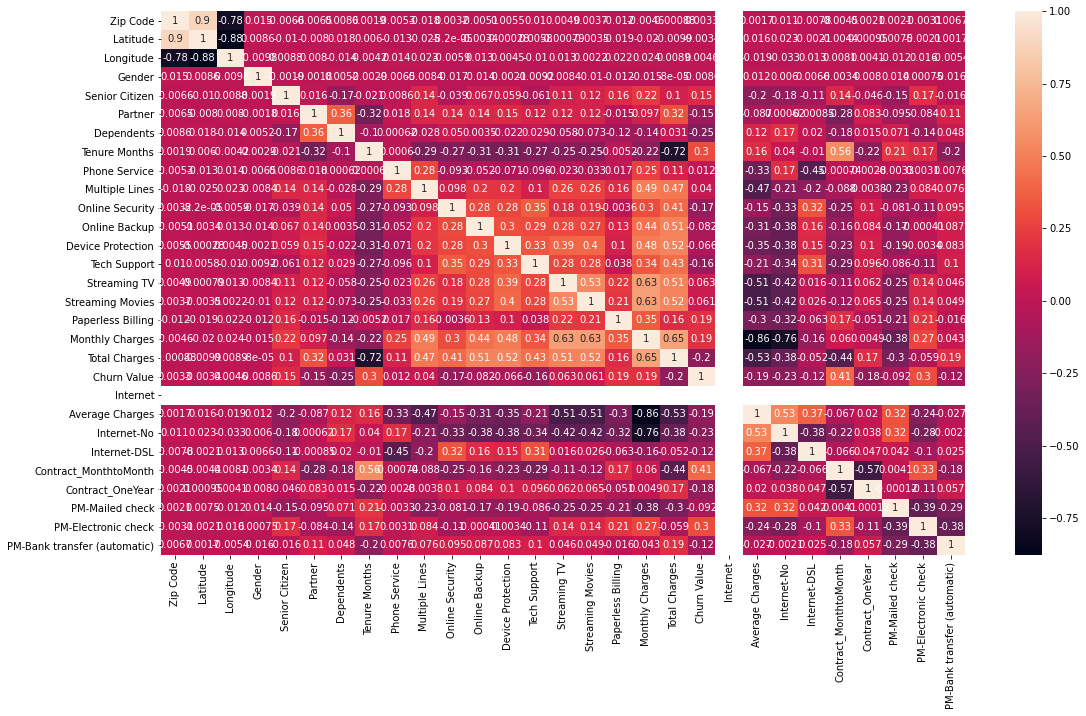

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize = (18,10))

sns.heatmap(churn_data.corr(), annot =True)   #Basic correlation plot to understand which features are correlated

# 4. Model Selection

## 4.1 Logistic Regression

In [92]:
churn_data.columns

Index(['CustomerID', 'Country', 'State', 'City', 'Zip Code', 'Lat Long',
       'Latitude', 'Longitude', 'Gender', 'Senior Citizen', 'Partner',
       'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines',
       'Internet Service', 'Online Security', 'Online Backup',
       'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
       'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges',
       'Total Charges', 'Churn Value', 'Churn Reason', 'Internet',
       'Average Charges', 'Internet-No', 'Internet-DSL',
       'Contract_MonthtoMonth', 'Contract_OneYear', 'PM-Mailed check',
       'PM-Electronic check', 'PM-Bank transfer (automatic)',
       'MonthlyChargesBinned', 'TotalChargesBinned', 'AverageChargesBinned'],
      dtype='object')

In [93]:
X = churn_data.iloc[:,np.r_[8:14,16:21,23, 25, 29:37]]
y= churn_data.iloc[:,27 ]

In [94]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [95]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

#
y_pred=logreg.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [96]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1159,  143],
       [ 203,  256]], dtype=int64)

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [98]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.8035207268597387
Precision: 0.6416040100250626
Recall: 0.5577342047930284


## 4.2 Decision Tree

In [99]:
import pandas as pd 
from sklearn import tree

X = churn_data.iloc[:,np.r_[8:14,16:21,23, 25, 29:37]]
Y= churn_data.iloc[:,27 ]

In [100]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [101]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1070,  232],
       [ 248,  211]], dtype=int64)

In [102]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.727427597955707
Precision: 0.4762979683972912
Recall: 0.4596949891067538


## 4.3 Random Forest

In [103]:
from sklearn.ensemble import RandomForestClassifier

Rfclf = RandomForestClassifier(random_state=15)
Rfclf.fit(X_train, y_train)
y_pred=Rfclf.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1154,  148],
       [ 249,  210]], dtype=int64)

In [104]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7745599091425327
Precision: 0.5865921787709497
Recall: 0.45751633986928103


## 4.4 XGBClassifier

In [113]:
from xgboost import XGBClassifier

xgbc = XGBClassifier(use_label_encoder=False)
xgbc.fit(X_train, y_train)
y_pred=xgbc.predict(X_test)

[23:18:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [114]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7904599659284497
Precision: 0.6136363636363636
Recall: 0.5294117647058824


## 4.5 SVM

In [106]:
from sklearn.preprocessing import StandardScaler
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
sc1=StandardScaler()
x_train_scaled = sc1.fit_transform(X_train)
x_test_scaled = sc1.fit_transform(X_test)
sc2=StandardScaler()
y_train_scaled = np.ravel(y_train)
y_test_scaled = np.ravel(y_test)

from sklearn import svm
model = svm.SVC(kernel='linear', degree=2)
model.fit(x_train_scaled, y_train_scaled)
y_pred=model.predict(x_test_scaled)
cnf_matrix = metrics.confusion_matrix(y_test_scaled, y_pred)
cnf_matrix



array([[1169,  133],
       [ 227,  232]], dtype=int64)

In [107]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7955706984667802
Precision: 0.6356164383561644
Recall: 0.5054466230936819


In [108]:
from sklearn.preprocessing import StandardScaler
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
sc1=StandardScaler()
x_train_scaled = sc1.fit_transform(X_train)
x_test_scaled = sc1.fit_transform(X_test)
sc2=StandardScaler()
y_train_scaled = np.ravel(y_train)
y_test_scaled = np.ravel(y_test)

from sklearn import svm
model = svm.SVC(kernel='poly', degree=2)
model.fit(x_train_scaled, y_train_scaled)
y_pred=model.predict(x_test_scaled)
cnf_matrix = metrics.confusion_matrix(y_test_scaled, y_pred)
cnf_matrix



array([[1193,  109],
       [ 254,  205]], dtype=int64)

In [109]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7938671209540034
Precision: 0.6528662420382165
Recall: 0.4466230936819172


In [110]:
from sklearn.preprocessing import StandardScaler
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
sc1=StandardScaler()
x_train_scaled = sc1.fit_transform(X_train)
x_test_scaled = sc1.fit_transform(X_test)
sc2=StandardScaler()
y_train_scaled = np.ravel(y_train)
y_test_scaled = np.ravel(y_test)

from sklearn import svm
model = svm.SVC(kernel='rbf', degree=2)
model.fit(x_train_scaled, y_train_scaled)
y_pred=model.predict(x_test_scaled)
cnf_matrix = metrics.confusion_matrix(y_test_scaled, y_pred)
cnf_matrix


array([[1187,  115],
       [ 240,  219]], dtype=int64)

In [111]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7984099943214082
Precision: 0.655688622754491
Recall: 0.477124183006536


## 4.6 Adaboost

In [140]:
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
# n_estimators = 50 (default value) 
# base_estimator = DecisionTreeClassifier (default value)
model.fit(X_train,y_train)
preds = model.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test_scaled, preds)
cnf_matrix

array([[1141,  161],
       [ 192,  267]], dtype=int64)

In [141]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7989778534923339
Precision: 0.6271186440677966
Recall: 0.5642701525054467


----------------------------------------------------------Not finished yet--------------------------------------------------------------------------------------